## Multi-task Regression Example

The data for this example are included in the repo, but to pre-process everything into numpy data you will need to run `prcp-testing/data-management/r_to_np_data.py`

In [1]:
import math
import torch
import gpytorch
import spectralgp
import prcp_utils
import data_getters

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_dtype(torch.float64)
torch.random.manual_seed(88);

### Getting out data
Now we choose the stations we want to generate time series for, and we'll take out the last 60 days as training data. For this example we use Boulder, Telluride, and Steamboat Springs

In [2]:
stns = [109, 129, 130]
out_list = data_getters.get_extrapolation_data(train_list=stns, test_cutoff=304)

The data getter returns a list of items, so there's a bit of unpacking necessary here

In [3]:
train_days = torch.tensor(out_list[0]).double()
train_dat = torch.tensor(out_list[1])
test_days = torch.tensor(out_list[2]).double()
test_dat = torch.tensor(out_list[3])
names = out_list[5]
#just clean up the USHCN names a bit
names = [",".join(n.split(",", 2)[:2]) for n in names]

### Defining the models

##### The latent models

The model provided by `spectralgp.models.SpectralModel` takes in a latent model and latent likelihood to define the GP over the log-spectral density. In the multi-task setting this latent model is shared among tasks, so we only need a single one. 

The simplest thing to do here is to allow the `SpectralModel` instances handle the data-dependent initialization of the latent model, so we define the latent model and likelihood as `None`, then redefine and pass them through to the next data dimension. The ensures that each output dimension has an appropriately initialized latent model and that the latent model is shared correctly

In [4]:
latent_lh = None
latent_mod = None

##### The Data Models
Define the lists of data models and likelihoods (one for each task), passing in the training data and shared latent model for each one

In [5]:
data_lh_list = []
data_mod_list = []
for dim in range(len(stns)):
    lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-3))
    
    data_lh_list.append(lh)
    data_mod_list.append(spectralgp.models.SpectralModel(train_days, train_dat[dim, :], likelihood=lh,
                                                        latent_mod=latent_mod, latent_lh=latent_lh))
    
    latent_mod = data_mod_list[dim].covar_module.latent_mod
    latent_lh = data_mod_list[dim].covar_module.latent_lh
    

None
None
None


### Defining the Samplers

***Gradient updates*** remain largely the same from the single-task setting, we need to define a single factory that handles creating loss functions for the hyperparameters of the model. 

***Elliptical slice sampling*** must happen differently than the 1-D case, since we need samples of the spectral densities corresponding to the kernel of each output dimension. Thus we make a list of factories that each defines a likelihood function of the spectral densities based on the data from that output dimension. Within each dimension the `ess_factory` initialization remains the same, so it's just a simple list comprehension of calls that are exactly like the 1-D case.

***The alternating sampler*** takes in the factories as defined above and runs in the same fashion as the single task case. For the multi-task case we provide the `spectralgp.samplers.GibbsAlternatingSampler` to handle generating updates to the hyperparameters and latent GP.

As usual we need to choose the total number of iterations as well as the number of SGD updates and ESS samples per iteration

In [6]:
total_iters = 1
sgd_iters = 10
ess_iters = 20

In [7]:
alt_sampler = spectralgp.samplers.AlternatingSampler(data_mod_list, data_lh_list,
                        spectralgp.sampling_factories.ss_multmodel_factory,
                        [spectralgp.sampling_factories.ess_factory] * len(stns),
                        numInnerSamples=ess_iters, numOuterSamples=sgd_iters, totalSamples=total_iters,
                        num_dims=1, num_tasks=len(stns)      
                        )

In [8]:
alt_sampler.num_tasks

3

Now we take the alternating sampler and run as usual

In [9]:
alt_sampler.run()

Task:  0 ; Iteration  0
Task:  1 ; Iteration  0
Task:  2 ; Iteration  0
Seconds for Iteration 0 : 75.24064898490906


### Processing Outputs

The updated hyperparameters are already in place in the appropriate models, so not much work is required there. The main output of the alternating sampler routine that we want to look at is the sampled latent GP, `alt_sampler.gsampled`. 

First: combine the training and testing days so we can look at predictions over the whole year and choose the number of sampled latent GPs for which we want to generate predictions.

In [10]:
days = torch.cat((train_days, test_days)).sort()[0] # just get all the days of the year together
n_samples = 10 # take the last 10 sampled latent GPs from each station

Just some simple storage set up to save our predictions and $\pm 2$ SD regions for shading

In [11]:
pred_data = torch.zeros(len(stns), len(days), n_samples)
lower_bds = torch.zeros(len(stns), len(days), n_samples)
upper_bds = torch.zeros(len(stns), len(days), n_samples)

In [12]:
alt_sampler.gsampled[0].size()

torch.Size([3, 100, 20])

Now loop through and generate predictions and shading regions for each sample of the latent GP for each recording station

In [13]:
for stn in range(len(stns)):
    samples = alt_sampler.gsampled[0][stn, :, -n_samples:].detach()
    data_mod = data_mod_list[stn]
    data_lh = data_lh_list[stn]
    
    for ii in range(n_samples):
        data_mod.covar_module.set_latent_params(samples[:, ii])
        data_mod.set_train_data(train_days, train_dat[stn, :]) # just to clear out the cache
        data_mod.eval()
        
        out = data_lh(data_mod(days))
        lower_bds[stn, :, ii], upper_bds[stn, :, ii] = out.confidence_region()
        pred_data[stn, :, ii] = out.mean
    
lower_bds = lower_bds.detach().numpy()
upper_bds = upper_bds.detach().numpy()
pred_data = pred_data.detach().numpy()
days = days.numpy()

### Plotting

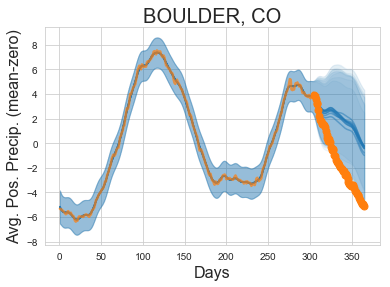

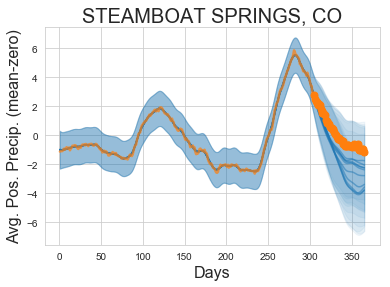

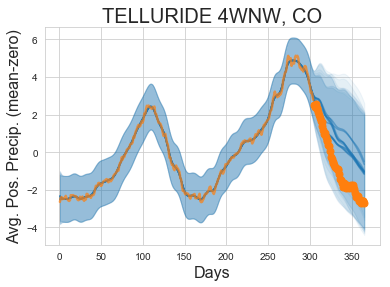

In [14]:
colors = cm.get_cmap("tab10")
sns.set_style("whitegrid")
sns.despine()
for stn in range(len(stns)):
    for ii in range(n_samples):
        if ii == 0:
            # plot with labels
            plt.plot(days, pred_data[stn, :, ii], color=colors(0), alpha=0.5,
                     label="Mean Prediction")
            plt.fill_between(days, lower_bds[stn,:,ii], upper_bds[stn,:,ii],
                             color=colors(0),alpha=0.06,
                             label=r'$\pm2$ SD')
        else:
            # plot without labels 
            plt.plot(days, pred_data[stn, :, ii], color=colors(0), alpha=0.5)
            plt.fill_between(days, lower_bds[stn,:,ii], upper_bds[stn,:,ii],
                             color=colors(0),alpha=0.06)
    plt.plot(train_days.numpy(), train_dat[stn, :].numpy(), color=colors(1),
             alpha=0.7, linewidth=2.5,
             label="Train Data")
    plt.plot(test_days.numpy(), test_dat[stn, :].numpy(), color=colors(1),
             linestyle="None", marker='.', markersize=14,
             label="Test Data")
    
    plt.xlabel("Days",fontsize=16)
    plt.ylabel("Avg. Pos. Precip. (mean-zero)",fontsize=16)
    plt.title(names[stn], fontsize=20)
    plt.show()